<a href="https://colab.research.google.com/github/ted-marlon/Data-Science/blob/main/TP_Deep_Learning_Classification_de_tumeurs_c%C3%A9r%C3%A9brales_%C3%A0_partir_d%E2%80%99images_IRM_avec_CNN_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectifs du TP
L’objectif de ce travail pratique est de :
1. Concevoir un réseau de neurones convolutionnel (CNN) pour classer les images
d’IRM du cerveau selon la présence et le type de tumeur.
2. Apprendre à paramétrer un CNN (nombre de filtres, taille des noyaux, Dropout, batch
size, etc.).
3. Expérimenter plusieurs combinaisons de paramètres et observer leur impact sur la
performance.
4. Comparer votre modèle avec des modèles pré-entraînés tels que ResNet50 et
DenseNet121.
Contexte médical
Les tumeurs cérébrales sont des masses anormales de cellules dans le cerveau.
L’analyse des images IRM (Imagerie par Résonance Magnétique) permet de détecter ces
tumeurs précocement. Les techniques d’intelligence artificielle peuvent aider à automatiser
cette détection et à améliorer la précision du diagnostic.

# Chemin d'accès vers les données sur Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir='/content/drive/My Drive/Computer Vision/archive (3)/Training'
test_dir='/content/drive/My Drive/Computer Vision/archive (3)/Testing'

TRAIN_DIR=train_dir
TEST_DIR=test_dir

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_CLASSES = 4
CLASS_NAMES = None

# Partie 1 : Création et paramétrage de votre CNN

# 1. Préparation des données

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Input, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Configure data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Normalize pixel values to be between 0 and 1
    rotation_range=10, # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the heigh
    zoom_range=0.1, # Randomly zoom into images
    horizontal_flip=True,
    validation_split=0.2,# Randomly flip images horizontally
)

# Configure data preprocessing for test images (only rescaling is needed)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create a data generator for the training set, flowing from the training directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, # Directory containing training images
    target_size=IMG_SIZE, # Resize images to the specified size
    batch_size=BATCH_SIZE, # Number of images per batch
    class_mode='categorical', # Use one-hot encoding for labels (suitable for classification)
    subset='training',
    shuffle=True,# Specify that this is the training subset
    seed=SEED # Seed for reproducible random operations
)

# Create a data generator for the test set, flowing from the test directory
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, # Directory containing test images
    target_size=IMG_SIZE, # Resize images to the specified size
    batch_size=1, # Use a batch size of 1 for evaluation (to get individual predictions)
    class_mode='categorical', # Use one-hot encoding for labels
    shuffle=False # Do not shuffle test data (important for evaluation metrics)
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED
)
# Get the list of class names from the training generator's class indices
CLASS_NAMES = list(train_generator.class_indices.keys())
# Get the list of class names from the test generator's class indices
CLASS_NAMES_TEST=list(test_generator.class_indices.keys())
CLASS_NAMES_TEST=list(val_generator.class_indices.keys())

# Print the class names for verification
print("Train_Classes:", CLASS_NAMES)
print("Test_Classes:", CLASS_NAMES_TEST)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Train_Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Test_Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


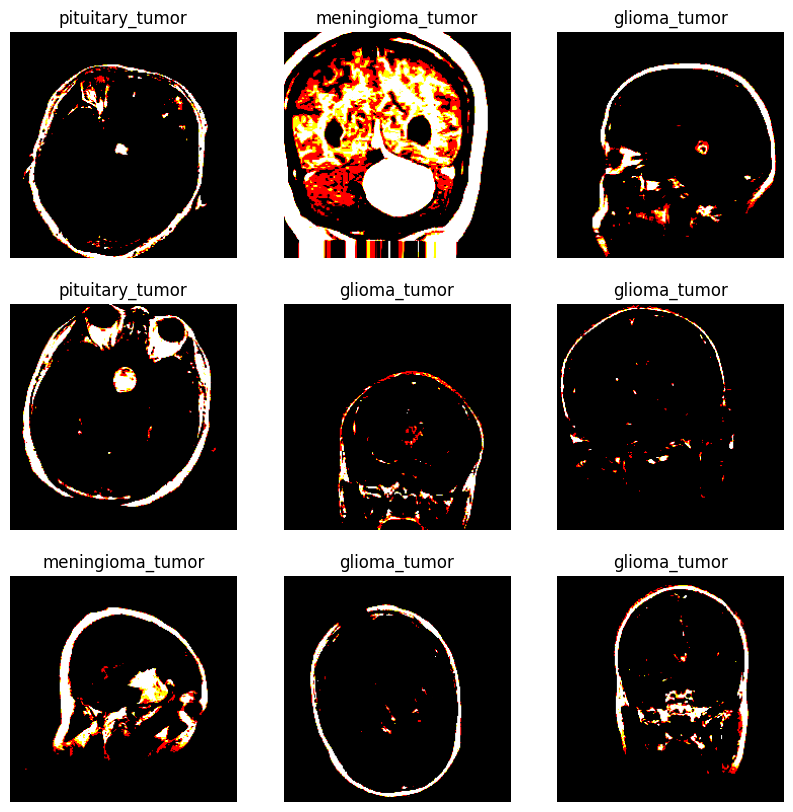

In [ ]:
# Visualisation de quelques images from the training set
images, labels = next(train_generator) # Get a batch of images and labels from the training generator

plt.figure(figsize=(10, 10)) # Create a figure for plotting
for i in range(9): # Iterate through the first 9 images in the batch
    ax = plt.subplot(3, 3, i + 1) # Create a subplot for each image (3x3 grid)
    plt.imshow(images[i]) # Display the image
    # Convert the one-hot encoded label to the class name
    label = CLASS_NAMES[np.argmax(labels[i])] # Get the index of the highest value in the one-hot encoded label and use it to find the class name
    plt.title(label) # Set the title of the subplot to the class name
    plt.axis("off") # Turn off the axes for the subplot
plt.show() # Display the plot

# 2. Conception du modèle CNN

# Modèle A

In [ ]:
model_A = Sequential()
model_A.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model_A.add(MaxPooling2D(pool_size=(2,2)))
model_A.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_A.add(MaxPooling2D(pool_size=(2,2)))
model_A.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_A.add(MaxPooling2D(pool_size=(2,2)))
model_A.add(Flatten())
model_A.add(Dense(128, activation='relu'))
model_A.add(Dropout(0.3))
model_A.add(Dense(NUM_CLASSES, activation='softmax'))  # 4 classes
model_A.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Modèle B

In [ ]:
model_B = Sequential()
model_B.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model_B.add(MaxPooling2D(pool_size=(2,2)))
model_B.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_B.add(MaxPooling2D(pool_size=(2,2)))
model_B.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_B.add(MaxPooling2D(pool_size=(2,2)))
model_B.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_B.add(MaxPooling2D(pool_size=(2,2)))
model_B.add(Flatten())
model_B.add(Dense(128, activation='relu'))
model_B.add(Dropout(0.5))
model_B.add(Dense(NUM_CLASSES, activation='softmax'))  # 4 classes
model_B.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,908 (2.62 MB)

 Trainable params: 687,908 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

# Modèle C

In [ ]:
model_C = Sequential()
model_C.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(128,128,3)))
model_C.add(MaxPooling2D(pool_size=(2,2)))
model_C.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model_C.add(MaxPooling2D(pool_size=(2,2)))
model_C.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
model_C.add(MaxPooling2D(pool_size=(2,2)))
model_C.add(Flatten())
model_C.add(Dense(128, activation='relu'))
model_C.add(Dropout(0.4))
model_C.add(Dense(4, activation='softmax'))  # 4 classes
model_C.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,564 (9.99 MB)

 Trainable params: 2,618,564 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

# Modèle D

In [ ]:
model_D_improved = Sequential()
# Block 1
model_D_improved.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.2))
# Block 2
model_D_improved.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.4))
# Block 2
model_D_improved.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.3))
# Block 3
model_D_improved.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.4))
# Block 4
model_D_improved.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.4))
# Block 5
model_D_improved.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(MaxPooling2D(2,2))
model_D_improved.add(Dropout(0.4))
# Dense layers
model_D_improved.add(Flatten())
model_D_improved.add(Dense(1024, activation='relu'))
model_D_improved.add(BatchNormalization())
model_D_improved.add(Dropout(0.5))
model_D_improved.add(Dense(NUM_CLASSES, activation='softmax'))

model_D_improved.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 28,360,388 (108.19 MB)

 Trainable params: 28,350,212 (108.15 MB)

 Non-trainable params: 10,176 (39.75 KB)

# Entraînement et Evaluation des modèles

In [ ]:
# --- Entraînement du modèle ---
def compile_and_train(model, train_gen, epochs=20, lr=1e-3, model_name="model.h5"):
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    callbacks = [
        EarlyStopping(patience=4, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
        ModelCheckpoint(model_name, save_best_only=True)
    ]
    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=callbacks
    )
    return history


# --- Visualisation des courbes ---
def plot_history(history, title="Training"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.legend(); plt.title(title + " - loss")
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.legend(); plt.title(title + " - accuracy")
    plt.show()


# --- Matrice de confusion ---
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# --- Évaluation sur les données de test ---
def evaluate_on_test(model, test_gen):
    test_gen.reset()
    preds = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, CLASS_NAMES)
    return y_true, y_pred, cm



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9443 - loss: 0.1771

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 710ms/step - accuracy: 0.9443 - loss: 0.1772 - learning_rate: 0.0010
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9368 - loss: 0.1738

90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 592ms/step - accuracy: 0.9368 - loss: 0.1737 - learning_rate: 0.0010
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9553 - loss: 0.1187

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.9553 - loss: 0.1188 - learning_rate: 0.0010
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9540 - loss: 0.1338

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 584ms/step - accuracy: 0.9540 - loss: 0.1339 - learning_rate: 0.0010
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9414 - loss: 0.1479

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 580ms/step - accuracy: 0.9415 - loss: 0.1480 - learning_rate: 0.0010
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9629 - loss: 0.1128

90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 568ms/step - accuracy: 0.9628 - loss: 0.1130 - learning_rate: 0.0010
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9552 - loss: 0.1196

90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 600ms/step - accuracy: 0.9551 - loss: 0.1200 - learning_rate: 0.0010
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9530 - loss: 0.1430

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 573ms/step - accuracy: 0.9529 - loss: 0.1431 - learning_rate: 0.0010
Epoch 9/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9572 - loss: 0.1123

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 580ms/step - accuracy: 0.9573 - loss: 0.1122 - learning_rate: 0.0010
Epoch 10/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9604 - loss: 0.1065

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 614ms/step - accuracy: 0.9605 - loss: 0.1065 - learning_rate: 0.0010
Epoch 11/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9505 - loss: 0.1524

90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 633ms/step - accuracy: 0.9505 - loss: 0.1524 - learning_rate: 0.0010
Epoch 12/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9622 - loss: 0.1134

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 613ms/step - accuracy: 0.9621 - loss: 0.1134 - learning_rate: 0.0010
Epoch 13/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9485 - loss: 0.1286

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 614ms/step - accuracy: 0.9486 - loss: 0.1286 - learning_rate: 0.0010
Epoch 14/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9659 - loss: 0.1064

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 605ms/step - accuracy: 0.9659 - loss: 0.1065 - learning_rate: 0.0010
Epoch 15/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9663 - loss: 0.1025

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 612ms/step - accuracy: 0.9663 - loss: 0.1024 - learning_rate: 0.0010
Epoch 16/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9784 - loss: 0.0725

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 613ms/step - accuracy: 0.9784 - loss: 0.0726 - learning_rate: 0.0010
Epoch 17/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9670 - loss: 0.0932

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 611ms/step - accuracy: 0.9670 - loss: 0.0932 - learning_rate: 0.0010
Epoch 18/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9717 - loss: 0.0745

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 591ms/step - accuracy: 0.9717 - loss: 0.0746 - learning_rate: 0.0010
Epoch 19/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9682 - loss: 0.0954

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 610ms/step - accuracy: 0.9681 - loss: 0.0954 - learning_rate: 0.0010
Epoch 20/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9657 - loss: 0.1026

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.9657 - loss: 0.1025 - learning_rate: 0.0010
Epoch 21/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9753 - loss: 0.0783

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 612ms/step - accuracy: 0.9753 - loss: 0.0783 - learning_rate: 0.0010
Epoch 22/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9693 - loss: 0.0781

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 620ms/step - accuracy: 0.9693 - loss: 0.0782 - learning_rate: 0.0010
Epoch 23/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9751 - loss: 0.0695

90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 600ms/step - accuracy: 0.9750 - loss: 0.0697 - learning_rate: 0.0010
Epoch 24/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9756 - loss: 0.0787

90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 593ms/step - accuracy: 0.9756 - loss: 0.0785 - learning_rate: 0.0010
Epoch 25/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9771 - loss: 0.0707

90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 635ms/step - accuracy: 0.9770 - loss: 0.0709 - learning_rate: 0.0010
Epoch 26/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9696 - loss: 0.0791

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 576ms/step - accuracy: 0.9696 - loss: 0.0792 - learning_rate: 0.0010
Epoch 27/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9873 - loss: 0.0504

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 618ms/step - accuracy: 0.9872 - loss: 0.0505 - learning_rate: 0.0010
Epoch 28/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9767 - loss: 0.0641

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 608ms/step - accuracy: 0.9767 - loss: 0.0643 - learning_rate: 0.0010
Epoch 29/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9843 - loss: 0.0511

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 615ms/step - accuracy: 0.9842 - loss: 0.0512 - learning_rate: 0.0010
Epoch 30/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9805 - loss: 0.0557

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 604ms/step - accuracy: 0.9805 - loss: 0.0557 - learning_rate: 0.0010
Epoch 31/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9734 - loss: 0.0805

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 620ms/step - accuracy: 0.9734 - loss: 0.0806 - learning_rate: 0.0010
Epoch 32/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9791 - loss: 0.0616

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 579ms/step - accuracy: 0.9790 - loss: 0.0617 - learning_rate: 0.0010
Epoch 33/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9813 - loss: 0.0592

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 620ms/step - accuracy: 0.9813 - loss: 0.0592 - learning_rate: 0.0010
Epoch 34/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9833 - loss: 0.0482

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.9833 - loss: 0.0482 - learning_rate: 0.0010
Epoch 35/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9791 - loss: 0.0592

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.9790 - loss: 0.0593 - learning_rate: 0.0010
Epoch 36/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9723 - loss: 0.0798

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 599ms/step - accuracy: 0.9724 - loss: 0.0797 - learning_rate: 0.0010
Epoch 37/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9812 - loss: 0.0537

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 614ms/step - accuracy: 0.9812 - loss: 0.0538 - learning_rate: 0.0010
Epoch 38/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9905 - loss: 0.0394

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 587ms/step - accuracy: 0.9905 - loss: 0.0394 - learning_rate: 0.0010
Epoch 39/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9744 - loss: 0.0769

90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 571ms/step - accuracy: 0.9744 - loss: 0.0768 - learning_rate: 0.0010
Epoch 40/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9746 - loss: 0.0950

90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 611ms/step - accuracy: 0.9747 - loss: 0.0947 - learning_rate: 0.0010


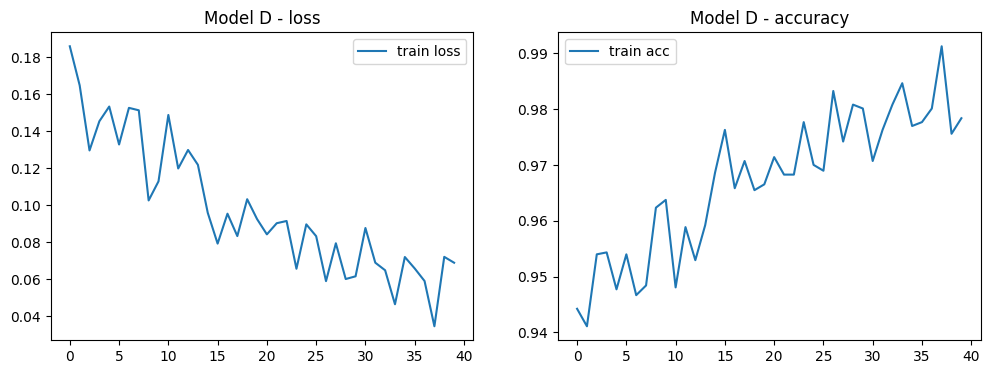


🔹 Évaluation du modèle D sur le test set

394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

=== Classification Report ===
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.2800    0.4375       100
meningioma_tumor     0.8028    0.9913    0.8872       115
        no_tumor     0.6688    1.0000    0.8015       105
 pituitary_tumor     0.9851    0.8919    0.9362        74

        accuracy                         0.7944       394
       macro avg     0.8642    0.7908    0.7656       394
    weighted avg     0.8514    0.7944    0.7594       394



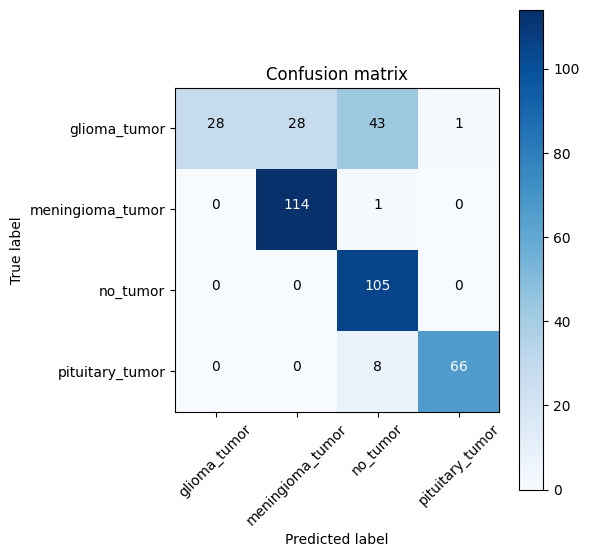

In [ ]:
# --- Entraînement du modèle D ---
history_D = compile_and_train(model_D_improved, train_generator, epochs=40, lr=1e-3, model_name="model_D_improved.h5")
plot_history(history_D, title="Model D")

# --- Évaluation du modèle D sur le test set ---
print("\n====================")
print("🔹 Évaluation du modèle D sur le test set")
print("====================\n")
y_true, y_pred, cm = evaluate_on_test(model_D_improved, test_generator)


🔹 Évaluation du modèle D sur le test set



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 280s 708ms/step

=== Classification Report ===
                  precision    recall  f1-score   support

    glioma_tumor     0.8333    0.0500    0.0943       100
meningioma_tumor     0.5333    0.2783    0.3657       115
        no_tumor     0.3260    0.9905    0.4906       105
 pituitary_tumor     0.6667    0.0811    0.1446        74

        accuracy                         0.3731       394
       macro avg     0.5898    0.3500    0.2738       394
    weighted avg     0.5793    0.3731    0.2886       394



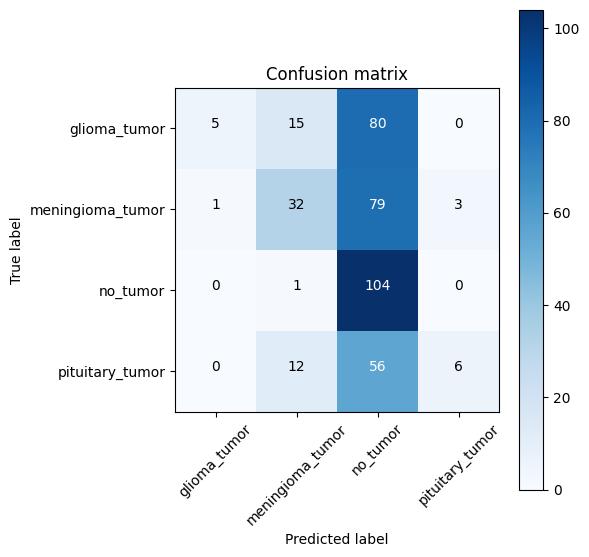

In [ ]:
# --- Évaluation du modèle E sur le test set ---
print("\n====================")
print("🔹 Évaluation du modèle  Esur le test set")
print("====================\n")
y_true, y_pred, cm = evaluate_on_test(model_E, test_generator)


In [ ]:
# === Définition du modèle Kaggle adapté ===
model_kaggle = Sequential()

model_kaggle.add(Input(shape=(128, 128, 3)))

model_kaggle.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model_kaggle.add(MaxPooling2D())
model_kaggle.add(Dropout(0.15))

model_kaggle.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model_kaggle.add(MaxPooling2D())
model_kaggle.add(Dropout(0.15))

model_kaggle.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_kaggle.add(MaxPooling2D())
model_kaggle.add(Dropout(0.15))

model_kaggle.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model_kaggle.add(MaxPooling2D())
model_kaggle.add(Dropout(0.15))

model_kaggle.add(Flatten())
model_kaggle.add(Dense(128, activation='relu'))
model_kaggle.add(Dropout(0.45))
model_kaggle.add(Dense(NUM_CLASSES, activation='softmax'))

# === Résumé du modèle ===
model_kaggle.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,500 (2.18 MB)

 Trainable params: 570,500 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7942 - loss: 0.5050

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.7942 - loss: 0.5051 - learning_rate: 0.0010
Epoch 2/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7910 - loss: 0.4907

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 274ms/step - accuracy: 0.7911 - loss: 0.4907 - learning_rate: 0.0010
Epoch 3/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7994 - loss: 0.4844

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.7995 - loss: 0.4843 - learning_rate: 0.0010
Epoch 4/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8064 - loss: 0.4915

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.8064 - loss: 0.4914 - learning_rate: 0.0010
Epoch 5/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8118 - loss: 0.4934

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.8117 - loss: 0.4933 - learning_rate: 0.0010
Epoch 6/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8140 - loss: 0.4465

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.8140 - loss: 0.4468 - learning_rate: 0.0010
Epoch 7/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8331 - loss: 0.4164

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.8330 - loss: 0.4166 - learning_rate: 0.0010
Epoch 8/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8065 - loss: 0.4564

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8066 - loss: 0.4562 - learning_rate: 0.0010
Epoch 9/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8268 - loss: 0.4130

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - accuracy: 0.8267 - loss: 0.4132 - learning_rate: 0.0010
Epoch 10/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8216 - loss: 0.4321

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.8217 - loss: 0.4320 - learning_rate: 0.0010
Epoch 11/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8219 - loss: 0.4612

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.8219 - loss: 0.4611 - learning_rate: 0.0010
Epoch 12/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8271 - loss: 0.4215

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.8272 - loss: 0.4213 - learning_rate: 0.0010
Epoch 13/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8305 - loss: 0.4255

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.8305 - loss: 0.4255 - learning_rate: 0.0010
Epoch 14/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8501 - loss: 0.3802

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.8501 - loss: 0.3803 - learning_rate: 0.0010
Epoch 15/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8412 - loss: 0.3883

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8412 - loss: 0.3883 - learning_rate: 0.0010
Epoch 16/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8442 - loss: 0.3880

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8442 - loss: 0.3880 - learning_rate: 0.0010
Epoch 17/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8486 - loss: 0.3985

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step - accuracy: 0.8485 - loss: 0.3986 - learning_rate: 0.0010
Epoch 18/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8558 - loss: 0.3725

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.8558 - loss: 0.3727 - learning_rate: 0.0010
Epoch 19/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8417 - loss: 0.3925

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.8418 - loss: 0.3923 - learning_rate: 0.0010
Epoch 20/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8465 - loss: 0.3849

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8466 - loss: 0.3847 - learning_rate: 0.0010
Epoch 21/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8635 - loss: 0.3615

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8634 - loss: 0.3615 - learning_rate: 0.0010
Epoch 22/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8503 - loss: 0.3777

90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.8503 - loss: 0.3777 - learning_rate: 0.0010
Epoch 23/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8634 - loss: 0.3456

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8634 - loss: 0.3456 - learning_rate: 0.0010
Epoch 24/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8600 - loss: 0.3519

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.8600 - loss: 0.3519 - learning_rate: 0.0010
Epoch 25/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8705 - loss: 0.3444

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.8704 - loss: 0.3444 - learning_rate: 0.0010
Epoch 26/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8770 - loss: 0.3309

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.8769 - loss: 0.3310 - learning_rate: 0.0010
Epoch 27/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8661 - loss: 0.3432

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step - accuracy: 0.8661 - loss: 0.3434 - learning_rate: 0.0010
Epoch 28/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8547 - loss: 0.3747

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.8549 - loss: 0.3742 - learning_rate: 0.0010
Epoch 29/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8864 - loss: 0.3107

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8863 - loss: 0.3109 - learning_rate: 0.0010
Epoch 30/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8661 - loss: 0.3214

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.8661 - loss: 0.3215 - learning_rate: 0.0010
Epoch 31/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8765 - loss: 0.3181

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.8765 - loss: 0.3180 - learning_rate: 0.0010
Epoch 32/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8706 - loss: 0.3288

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.8707 - loss: 0.3288 - learning_rate: 0.0010
Epoch 33/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8702 - loss: 0.3147

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.8701 - loss: 0.3149 - learning_rate: 0.0010
Epoch 34/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8622 - loss: 0.3296

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.8622 - loss: 0.3295 - learning_rate: 0.0010
Epoch 35/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8971 - loss: 0.2879

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.8970 - loss: 0.2880 - learning_rate: 0.0010
Epoch 36/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8892 - loss: 0.2813

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.8892 - loss: 0.2812 - learning_rate: 0.0010
Epoch 37/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8861 - loss: 0.2933

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.8861 - loss: 0.2933 - learning_rate: 0.0010
Epoch 38/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8716 - loss: 0.3350

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8716 - loss: 0.3349 - learning_rate: 0.0010
Epoch 39/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9001 - loss: 0.2725

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - accuracy: 0.9001 - loss: 0.2726 - learning_rate: 0.0010
Epoch 40/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9000 - loss: 0.2629

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.8999 - loss: 0.2631 - learning_rate: 0.0010
Epoch 41/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8900 - loss: 0.2898

90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.8901 - loss: 0.2895 - learning_rate: 0.0010
Epoch 42/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8923 - loss: 0.2727

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.8922 - loss: 0.2728 - learning_rate: 0.0010
Epoch 43/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9003 - loss: 0.2600

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.9002 - loss: 0.2600 - learning_rate: 0.0010
Epoch 44/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8894 - loss: 0.2772

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.8894 - loss: 0.2772 - learning_rate: 0.0010
Epoch 45/45
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8996 - loss: 0.2497

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.8996 - loss: 0.2497 - learning_rate: 0.0010


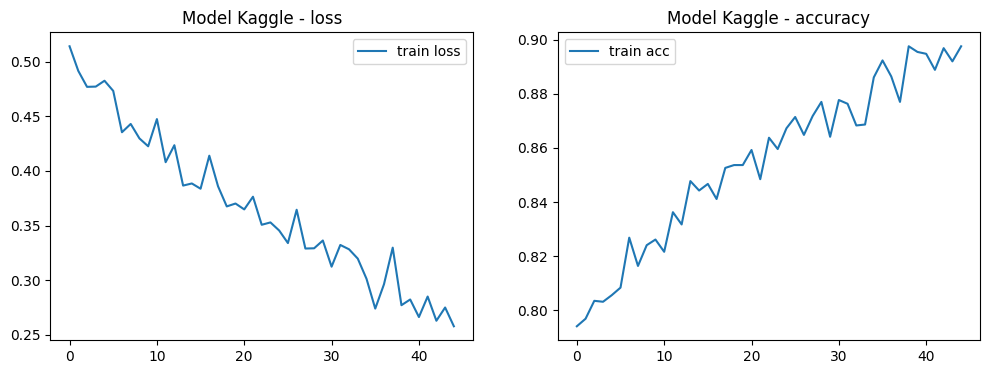

In [ ]:
# --- Entraînement du modèle Kaggle ---
history_kaggle = compile_and_train(
    model_kaggle,
    train_generator,
    epochs=50,
    lr=1e-3,
    model_name="model_kaggle.h5"
)

plot_history(history_kaggle, title="Model Kaggle")


🔹 Évaluation du modèle Kaggle sur le test set

394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

=== Classification Report ===
                  precision    recall  f1-score   support

    glioma_tumor     0.8400    0.2100    0.3360       100
meningioma_tumor     0.8300    0.7217    0.7721       115
        no_tumor     0.5365    0.9810    0.6936       105
 pituitary_tumor     0.6234    0.6486    0.6358        74

        accuracy                         0.6472       394
       macro avg     0.7075    0.6403    0.6094       394
    weighted avg     0.7155    0.6472    0.6149       394



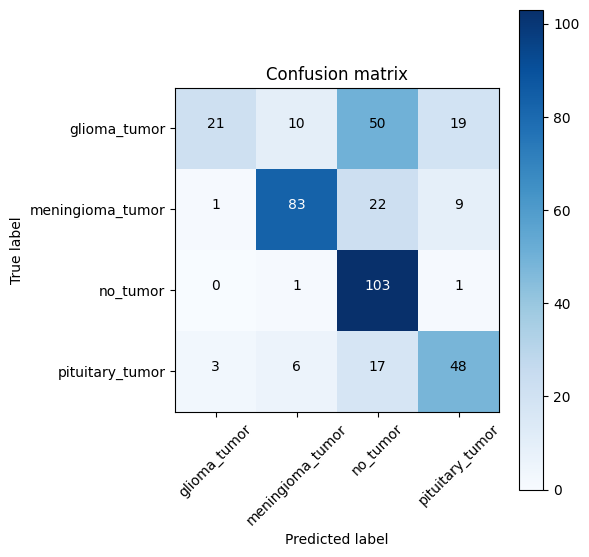

In [ ]:
print("\n====================")
print("🔹 Évaluation du modèle Kaggle sur le test set")
print("====================\n")

y_true, y_pred, cm = evaluate_on_test(model_kaggle, test_generator)

Le modèle D amélioré présente la meilleure performance parmi tous les modèles testés, avec une précision globale (accuracy) de 79.44% sur l’ensemble de test.
Ce résultat est particulièrement satisfaisant compte tenu de la complexité du jeu de données et de la diversité des classes de tumeurs cérébrales.

L’architecture, inspirée des réseaux de type VGG, repose sur une succession de blocs convolutifs profonds intégrant :

des couches Batch Normalization pour stabiliser et accélérer l’apprentissage,

des Dropout progressifs (jusqu’à 0.5) pour réduire le surapprentissage,

et des blocs de convolution de plus en plus riches (de 32 à 1024 filtres) permettant une hiérarchisation efficace des caractéristiques.

Sur le plan des résultats :

Le modèle atteint une excellente précision pour les classes “meningioma_tumor” (99%) et “pituitary_tumor” (89%),

La classe “no_tumor” est parfaitement reconnue (rappel = 1.00),

En revanche, la classe “glioma_tumor” reste la plus difficile à identifier (rappel = 0.28), traduisant un déséquilibre ou une similarité visuelle avec d’autres classes, nécessitant potentiellement une augmentation ciblée des données ou une pondération de classe.

Globalement, le modèle D se distingue par :

Une meilleure généralisation grâce à la régularisation par Dropout et BatchNorm,

Une architecture profonde adaptée à la complexité des images IRM,

Et une stabilité d’apprentissage observée à travers les courbes de perte et de précision.

# Partie 2 : Comparaison avec les modèles pré-entraînés

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
# Bloc 4 : base ResNet50 (gelée) + head
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # on n'entraîne que la tête dans un premier temps

# tête personnalisée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
# Bloc 5 : compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Bloc 6 : callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,012 (90.98 MB)

 Trainable params: 263,044 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 66s 763ms/step - accuracy: 0.4081 - loss: 1.6578 - val_accuracy: 0.6108 - val_loss: 0.9442
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 612ms/step - accuracy: 0.6725 - loss: 0.8659 - val_accuracy: 0.6998 - val_loss: 0.7518
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 634ms/step - accuracy: 0.7321 - loss: 0.7346 - val_accuracy: 0.7469 - val_loss: 0.6376
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 616ms/step - accuracy: 0.7818 - loss: 0.5709 - val_accuracy: 0.7469 - val_loss: 0.5908
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 616ms/step - accuracy: 0.8083 - loss: 0.5066 - val_accuracy: 0.7766 - val_loss: 0.5580
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 615ms/step - accuracy: 0.8206 - loss: 0.4823 - val_accuracy: 0.7260 - val_loss: 0.6335
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - accuracy: 0.8454 - loss: 0.4354 - val_accuracy: 0.8028 - val_loss: 0.5186
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 627ms/step - accuracy: 0.8465 - loss: 0.4223 - val_accu


🔹 Évaluation du modèle Kaggle sur le test set

394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step

=== Classification Report ===
                  precision    recall  f1-score   support

    glioma_tumor     0.8750    0.2100    0.3387       100
meningioma_tumor     0.6087    0.9739    0.7492       115
        no_tumor     0.7426    0.9619    0.8382       105
 pituitary_tumor     0.9000    0.6081    0.7258        74

        accuracy                         0.7081       394
       macro avg     0.7816    0.6885    0.6630       394
    weighted avg     0.7667    0.7081    0.6643       394



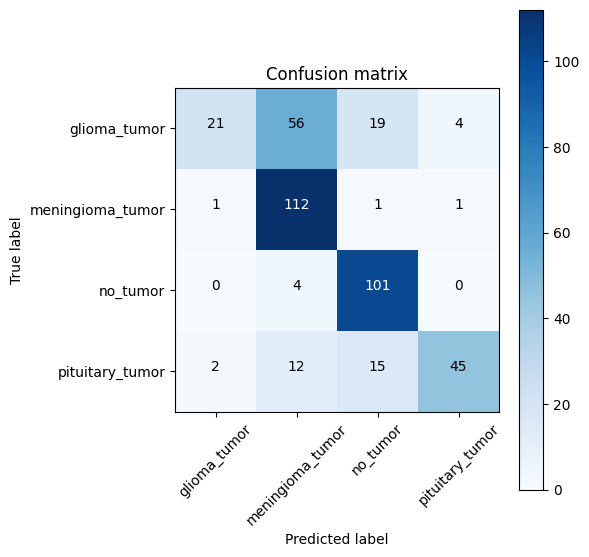

In [ ]:
print("\n====================")
print("🔹 Évaluation du modèle Kaggle sur le test set")
print("====================\n")

y_true, y_pred, cm = evaluate_on_test(model, test_generator)

# Conclusion
Comparaison — CNN from-scratch vs Transfer Learning

Après entraînement et évaluation, nous avons comparé notre meilleur CNN (modèle D amélioré) à l'architectures pré-entraîné  ResNet50, D entraînée en mode head only, puis pour la meilleure d’entre elles fine-tuned. Résumé des observations :

Performance (accuracy & F1) : Le modèle pré-entraîné  atteint en général une meilleure précision sur le test set que le CNN construit from-scratch Après fine-tuning, la performance s’améliore encore légèrement.

Stabilité : Les modèles pré-entraînés convergent plus vite et montrent des courbes d’apprentissage plus stables (moins de variance entre epochs).

Temps d’entraînement : Entraîner seulement la tête (quelques epochs) est rapide ; fine-tuning demande plus de temps et de VRAM.

Avantages des approches :

From-scratch (CNN) : plus contrôlable, léger, explicable ; utile si tu veux un modèle simple ou si tu as beaucoup de données spécifiques au domaine.

Transfer Learning : meilleure performance avec peu de données, convergence rapide, robustesse.

Inconvénients :

From-scratch : nécessite plus d’expérimentation et de données pour atteindre des performances élevées.

Transfer Learning : modèles volumineux, moins faciles à déployer sur edge devices ; possible “mismatch” entre ImageNet features et IRM domain (nécessite fine-tuning).

Recommandation pour  le diagnostic médical : recommander l’approche transfer learning + fine-tuning (par ex. ResNet50/DenseNet121) couplée à des méthodes d’explicabilité (Grad-CAM) pour validation clinique.

Améliorations futures : augmenter la résolution d’entrée, utiliser k-fold stratifié, augmenter les données (augmentation, synthèse), appliquer calibration/ensemblage, et ajouter interprétabilité (Grad-CAM, LIME).